In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import os

In [2]:
# Load and preprocess the data
data = []  # List to store image data
labels = []  # List to store labels

# Define a function to extract the person label from the file name
def extract_person_label(file_name):
    return int(file_name.split('.')[0].replace('subject', '')) - 1  # Subtract 1 to make labels start from 0

# Load data and labels
# Assuming the dataset files are in the 'dataset' directory
dataset_dir = './archive'

for file_name in os.listdir(dataset_dir):
    img = plt.imread(os.path.join(dataset_dir, file_name))
    #print(file_name,img.shape)
    data.append(img.flatten())  # Flatten image into a 1D array
    labels.append(extract_person_label(file_name))

data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
len(X_train),len(y_train)


[[109 111 124 ...  68  68  68]
 [111  95  90 ...  68  68  68]
 [130 130 130 ...  68  68  68]
 ...
 [130 130 130 ...  68  68  68]
 [109 112 124 ...  68  68  68]
 [130 130 130 ...  68  68  68]]
[ 1  5 13  5  6  0 13  5  7  2 13 14 10  9  4  2 10  7  8  2 12  9  1  3
 10  4  0 14  7  5  2  1 12  0 11  4  3  9 10  0  6  0 11  6 10  8  0 14
 11 11  4  9  9  0  7 13  4  5 13  7  8 12  2  2 12  0  1  6 11 12  5  9
 10 12 13  5 12  3  5 14  8  6  3  3  8  3  7  4  2  4  1  3 14 14  6  6
  4 10  6  1 14  8  7  9 10  4  7 11  1 14  1 13  4  6  0 14  7  5  1  9
 10  0  8  6  3  3  2 11  9 13  1  3]


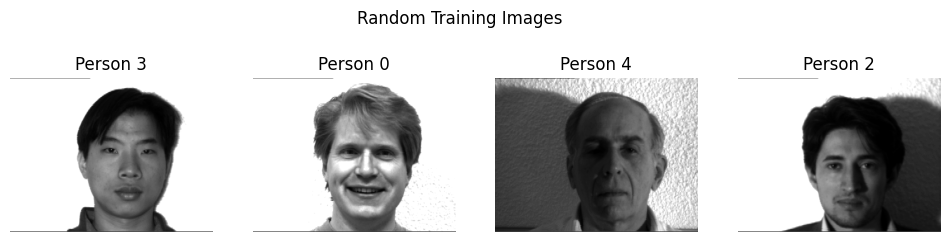

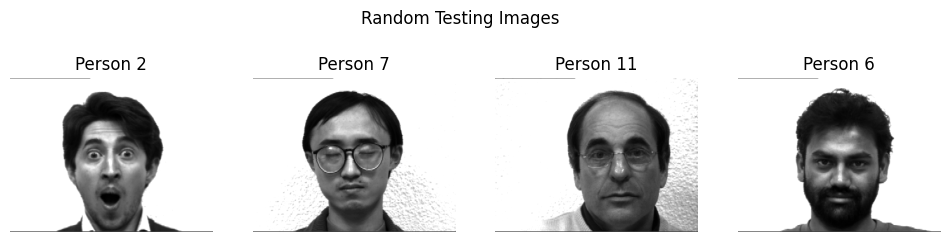

In [312]:
# Randomly select four indices from the training dataset
train_indices = random.sample(range(len(X_train)), 4)

# Randomly select four indices from the testing dataset
test_indices = random.sample(range(len(X_test)), 4)

# Function to display images
def display_images(images, labels, title):
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    for i, (image, label) in enumerate(zip(images, labels), 1):
        plt.subplot(1, 4, i)
        plt.imshow(image.reshape((243, 320)), cmap='gray')
        plt.title(f"Person {label}")
        plt.axis('off')
    plt.show()

# Display four random training images
train_images_to_display = X_train[train_indices]
train_labels_to_display = y_train[train_indices]
display_images(train_images_to_display, train_labels_to_display, "Random Training Images")

# Display four random testing images
test_images_to_display = X_test[test_indices]
test_labels_to_display = y_test[test_indices]
display_images(test_images_to_display, test_labels_to_display, "Random Testing Images")

In [313]:
_images_size = len(X_train[0])
_output_size = len(set(y_train))
print(_images_size, _output_size)
print

77760 15


In [314]:
def sigmoid(x,deriv=False):
    if deriv == False:
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    else:
        return x * (1 - x)
def relu(x, deriv=False):
    if deriv == False:
        return np.maximum(0,x)
    else:
        return (x > 0) * 1
def one_hot_encode(num,size):
    ret = np.zeros(size)
    ret[num]=1
    return ret
class NeuralNetwork:
    def __init__(self,
                 input_size,
                 hidden_layers, #[[neuron_count, activationFunction]]
                 output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.layers = []
        self.weights = []
        self.biases = []
        self.activations = []

        #init activations, weights and biases for hidden layers 
        for i in range(len(hidden_layers)):
            if (i==0):#if it is the first layer then the input dimensions to this layer will be == to the input_size
                input_dim = input_size
            else:#else it the input dim will be == to the output of the previous layer
                input_dim = hidden_layers[i-1][0]
            output_dim = hidden_layers[i][0] #output dimensions will be equal to the number of neurons in a layer
            self.weights.append(np.random.randn(input_dim,output_dim)) #for a layer, add a matrix of dimensions (inputs_to_a_layer, number_of_neurons)
            self.biases.append(np.zeros((1,output_dim))) #every neuron gets a bias
            self.activations.append(hidden_layers[i][1])

        #init activations, weights and biases for output layers
        self.weights.append(np.random.randn(hidden_layers[-1][0], output_size))
        self.biases.append(np.zeros((1, output_size)))
        self.activations.append(sigmoid)  # Default activation function for output layer is sigmoid

        #unpack the hidden_layers
        self.hidden_layers = []
        for i in hidden_layers:
            self.hidden_layers.append(i[0])
            
    def forward(self,input):
        #print(input)
        self.layers = [] #refresh the layers since they have to store the output
        for i in range(len(self.hidden_layers)):
            if(i==0): #if input is from input layer
                layer_input = np.dot(input,self.weights[i])+self.biases[i] #dot the inputs with the weights matrix of the first layer
            else:
                layer_input = np.dot(self.layers[-1],self.weights[i])+self.biases[i] #dot the previou layer output with the weights matrix of the current layer
            layer_output = self.activations[i](layer_input) #apply activation function
            self.layers.append(layer_output) #add the layer output to the layer list

        #caluculate the network output
        output_layer_input = np.dot(self.layers[-1], self.weights[-1]) + self.biases[-1]
        network_output = self.activations[-1](output_layer_input)
        self.layers.append(network_output)

        return network_output
    
    def backward(self, x, y, learning_rate):
        deltas = []
        error = y - self.layers[-1]
        delta_output = error * self.activations[-1](self.layers[-1],True)
        deltas.append(delta_output)

        for i in range(len(self.hidden_layers), 0, -1):
            error = deltas[-1].dot(self.weights[i].T)
            delta_hidden = error * self.activations[i-1](self.layers[i - 1],True)  
            deltas.append(delta_hidden)

        deltas.reverse()

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] += np.dot(deltas[i],self.layers[i].T) * learning_rate
            self.biases[i] += np.sum(deltas[i], axis=0, keepdims=True) * learning_rate

    def train(self, X, y, learning_rate, epochs):
        for epoch in range(epochs):
            data_set = list(zip(X,y))
            random.shuffle(data_set)
            #print(data_set)
            X = []
            y = []
            for i in data_set:
                X.append(i[0])
                y.append(i[1])
            outputs = []
            for i in range(len(X)):
                input_data = X[i]
                target = y[i]

                #forward prop
                outputs.append(self.forward(input_data))

                #back prop
                self.backward(input_data, target, learning_rate)

            # Calculate and print the mean squared error for this epoch
            mse=0
            for m in range(len(outputs)):
                mse+= ((y[m]-outputs[m])**2)
                #print('y[',m,'] - outputs[',m,'] = ',y[m],' - ',outputs[m])
            if(epoch%1 == 0):
                print(np.mean(mse))
                #print(f"Epoch {epoch + 1}/{epochs}, Mean Squared Error: {mse:.4f}")
#creating the network
input_size = _images_size
hidden_layers = [[1050, sigmoid], [700, sigmoid],[150, relu]]  # 3 hidden layers with 700, 800, 500 neurons
output_size = _output_size
# Create a neural network
nn = NeuralNetwork(input_size, hidden_layers, output_size)

In [315]:
train_set_x = X_train
train_set_y = []
for i in y_train:
    train_set_y.append(one_hot_encode(i,_output_size))

In [316]:
print(train_set_x[0])
print(train_set_y[0])
print(y_train[0])

[109 111 124 ...  68  68  68]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1


In [317]:
nn.train(train_set_x,train_set_y,0.2,20)

41.74152636737184
11.283871939361099
9.157023221727776
8.66365001399629
8.46998429089095
8.373710337391726
8.319863639021724
8.286672271507543
8.265450493618397
8.250881166132105
8.241007288407067
8.233781767119284
8.228555250637276
8.224628536632908
8.221609491468344
8.219409500559706
8.217671918924061
8.216186441775841
8.215165208132374
8.21433823902497


In [318]:
def make_one(array):
    #print(array)
    max_val = max(array)
    array = array/max_val
    for i in range(len(array)):
        if(array[i]==1):
            array[i]=1
        else:
            array[i]=0
    return array
predict = []
for i in X_train:
    predict.append(nn.forward(i))
    predict[-1][0]=make_one(predict[-1][0])
count = 0
for i in range(len(y_train)):
    #print(predict[i][0], predict[i][0][y_train[i]], y_train[i])
    if(predict[i][0][y_train[i]]==1):
        count+=1
print("accuracy = ",count/len(y_train))

accuracy =  0.07575757575757576
